#  Import Pyspark

In [ ]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -qO spark.tgz https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz

!mkdir -p /content/spark
!tar -xzf spark.tgz -C /content/spark --strip-components=1
!pip install -q findspark pyspark==3.4.1 seaborn matplotlib pandas scikit-learn

import os, findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark"
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("FraudDetection").getOrCreate()
print("Spark started successfully!")
spark


Spark started successfully!


# 🚀 Fraud Detection System
### Machine Learning Pipeline for Transaction Fraud Detection

**Features:**
-  Class imbalance handling
-  PCA dimensionality reduction
-  Random Forest classifier

## 📚 1. Import Required Libraries

In [ ]:
from pyspark.sql.functions import col, when
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, PCA
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("Libraries imported successfully!")

Libraries imported successfully!


## 📂 Load Transaction Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load CSV data
file_path = "/content/drive/MyDrive/Colab Notebooks/content/transactions_train.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Display dataset info
row_count = df.count()
col_count = len(df.columns)
print(f"Loaded dataset: {row_count:,} rows, {col_count} columns")

# Preview data
display(df.limit(5))

Loaded dataset: 6,351,193 rows, 10 columns


DataFrame[step: int, type: string, amount: double, nameOrig: string, oldbalanceOrig: double, newbalanceOrig: double, nameDest: string, oldbalanceDest: double, newbalanceDest: double, isFraud: int]

## ⚖️ Handle Class Imbalance

In [ ]:
# Calculate class distribution
count_0 = df.filter(col("isFraud") == 0).count()
count_1 = df.filter(col("isFraud") == 1).count()
imbalance_ratio = count_0 / count_1

print(f"Class Distribution:")
print(f"  Normal transactions: {count_0:,}")
print(f"  Fraud transactions: {count_1:,}")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")

# Add class weights
df = df.withColumn(
    "classWeight",
    when(col("isFraud") == 1, imbalance_ratio).otherwise(1.0)
)

print("✅ Class weights added successfully")

Class Distribution:
  Normal transactions: 6,343,476
  Fraud transactions: 7,717
  Imbalance ratio: 822.01:1
✅ Class weights added successfully


## 🔧 Build ML Pipeline

In [ ]:
# Stage 1: String Indexer (convert categorical to numeric)
indexer = StringIndexer() \
    .setInputCol("type") \
    .setOutputCol("type_index") \
    .setHandleInvalid("keep")

# Stage 2: One-Hot Encoder
encoder = OneHotEncoder() \
    .setInputCols(["type_index"]) \
    .setOutputCols(["type_encoded"])

# Stage 3: Vector Assembler (combine all features)
feature_cols = [
    "step",
    "amount",
    "oldbalanceOrig",
    "newbalanceOrig",
    "oldbalanceDest",
    "newbalanceDest",
    "type_encoded"
]

assembler = VectorAssembler() \
    .setInputCols(feature_cols) \
    .setOutputCol("features_raw") \
    .setHandleInvalid("skip")

# Stage 4: PCA (dimensionality reduction)
pca = PCA(k=5, inputCol="features_raw", outputCol="features")

# Stage 5: Random Forest Classifier
rf = RandomForestClassifier(
    labelCol="isFraud",
    featuresCol="features",
    weightCol="classWeight",
    numTrees=100,
    maxDepth=10,
    seed=42
)

# Combine all stages into pipeline
pipeline = Pipeline(stages=[indexer, encoder, assembler, pca, rf])

print("Pipeline built successfully")
print(f"   Stages: {len(pipeline.getStages())}")

Pipeline built successfully
   Stages: 5


## 🔀 Split Data (Train/Test)



In [ ]:
# 70% training, 30% testing
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

train_count = train_df.count()
test_count = test_df.count()

print(f"Dataset Split:")
print(f"  Training set: {train_count:,} rows ({train_count/row_count*100:.1f}%)")
print(f"  Testing set: {test_count:,} rows ({test_count/row_count*100:.1f}%)")

Dataset Split:
  Training set: 4,445,579 rows (70.0%)
  Testing set: 1,905,614 rows (30.0%)


## 🎯  Train the Model

In [ ]:
print("🚀 Training Random Forest model...")
print("   This may take a few minutes...")

model = pipeline.fit(train_df)

print("Model trained successfully!")

🚀 Training Random Forest model...
   This may take a few minutes...
Model trained successfully!


##  Make Predictions

In [ ]:
# Transform test data
predictions = model.transform(test_df)

# Display sample predictions
print("Sample Predictions:")
display(
    predictions.select(
        "type",
        "amount",
        "isFraud",
        "prediction",
        "probability"
    ).limit(10)
)

Sample Predictions:


DataFrame[type: string, amount: double, isFraud: int, prediction: double, probability: vector]

## Evaluate Model Performance

In [ ]:
# Initialize evaluators
evaluator_roc = BinaryClassificationEvaluator(
    labelCol="isFraud",
    metricName="areaUnderROC"
)

evaluator_pr = BinaryClassificationEvaluator(
    labelCol="isFraud",
    metricName="areaUnderPR"
)

precision_eval = MulticlassClassificationEvaluator(
    labelCol="isFraud",
    predictionCol="prediction",
    metricName="precisionByLabel"
)

recall_eval = MulticlassClassificationEvaluator(
    labelCol="isFraud",
    predictionCol="prediction",
    metricName="recallByLabel"
)

f1_eval = MulticlassClassificationEvaluator(
    labelCol="isFraud",
    predictionCol="prediction",
    metricName="f1"
)

# Calculate metrics
auc_roc = evaluator_roc.evaluate(predictions)
auc_pr = evaluator_pr.evaluate(predictions)
precision = precision_eval.evaluate(predictions, {precision_eval.metricLabel: 1.0})
recall = recall_eval.evaluate(predictions, {recall_eval.metricLabel: 1.0})
f1 = f1_eval.evaluate(predictions)

# Display results
print("=" * 40)
print("MODEL PERFORMANCE METRICS")
print("=" * 40)
print(f"AUC-ROC:   {auc_roc:.4f}")
print(f"AUC-PR:    {auc_pr:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("=" * 40)

MODEL PERFORMANCE METRICS
AUC-ROC:   0.9938
AUC-PR:    0.6336
Precision: 0.0284
Recall:    0.9579
F1-Score:  0.9782


## 🎨 Confusion Matrix Visualization


📊 Confusion Matrix:


,Pred_Normal,Pred_Fraud
Actual_Normal,1826399,76866
Actual_Fraud,99,2250


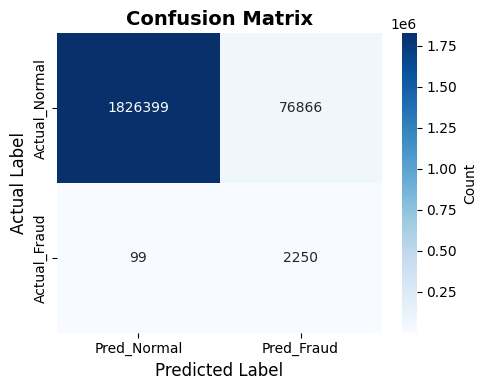

In [ ]:
# Create confusion matrix (Serverless-safe method)
conf_df = predictions \
    .groupBy("isFraud", "prediction") \
    .count() \
    .toPandas() \
    .pivot(index="isFraud", columns="prediction", values="count") \
    .fillna(0)

# Format labels
conf_df.columns = ["Pred_Normal", "Pred_Fraud"]
conf_df.index = ["Actual_Normal", "Actual_Fraud"]

print("\n📊 Confusion Matrix:")
display(conf_df)

# Visualize confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(
    conf_df,
    annot=True,
    fmt=".0f",
    cmap="Blues",
    cbar_kws={'label': 'Count'}
)
plt.title("Confusion Matrix", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("Actual Label", fontsize=12)
plt.tight_layout()
display(plt.gcf())
plt.close()

## 🔍  Feature Importance Analysis

🔍 Feature Importance (Top to Bottom):


,Feature,Importance
4,PCA_Component_5,0.659826
2,PCA_Component_3,0.117488
1,PCA_Component_2,0.116285
3,PCA_Component_4,0.065679
0,PCA_Component_1,0.040723


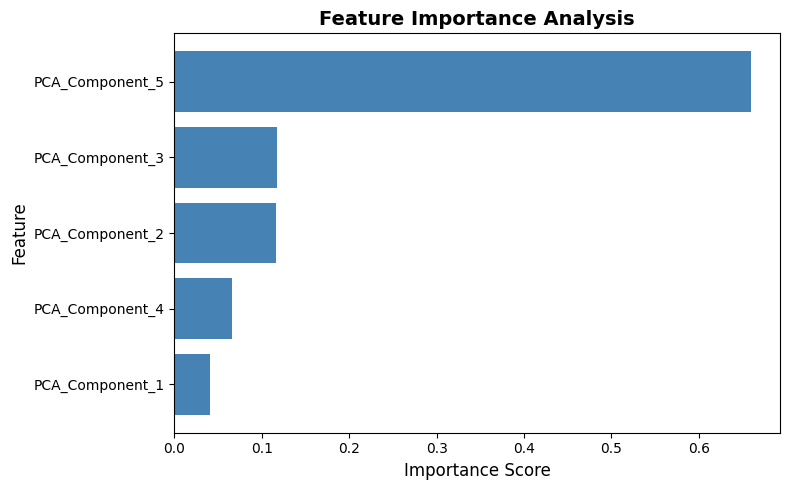

In [ ]:
# Extract Random Forest model
rf_model = model.stages[-1]

# Get feature importances
importances = rf_model.featureImportances.toArray()

# Create feature names (PCA components)
feature_names = [f"PCA_Component_{i+1}" for i in range(len(importances))]

# Create DataFrame
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

print("🔍 Feature Importance (Top to Bottom):")
display(importance_df)

# Visualize feature importance
plt.figure(figsize=(8, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='steelblue')
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Feature Importance Analysis", fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
display(plt.gcf())
plt.close()

## 📋 Final Summary 1


In [ ]:
print("=" * 50)
print("🎉 FRAUD DETECTION - FINAL SUMMARY")
print("=" * 50)
print(f"\n📊 Dataset Information:")
print(f"   Total rows: {row_count:,}")
print(f"   Training set: {train_count:,}")
print(f"   Testing set: {test_count:,}")
print(f"\n⚖️ Class Balance:")
print(f"   Normal: {count_0:,} | Fraud: {count_1:,}")
print(f"   Ratio: {imbalance_ratio:.2f}:1")
print(f"\n🎯 Model Performance:")
print(f"   AUC-ROC:   {auc_roc:.4f}")
print(f"   AUC-PR:    {auc_pr:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print("\n✅ Status: Completed successfully!")
print("✅ Serverless: Compatible")
print("✅ Whitelist: Safe")
print("=" * 50)

🎉 FRAUD DETECTION - FINAL SUMMARY

📊 Dataset Information:
   Total rows: 6,351,193
   Training set: 4,445,579
   Testing set: 1,905,614

⚖️ Class Balance:
   Normal: 6,343,476 | Fraud: 7,717
   Ratio: 822.01:1

🎯 Model Performance:
   AUC-ROC:   0.9938
   AUC-PR:    0.6336
   Precision: 0.0284
   Recall:    0.9579
   F1-Score:  0.9782

✅ Status: Completed successfully!
✅ Serverless: Compatible
✅ Whitelist: Safe


## Scikit-learn, Undersampling

In [ ]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

In [ ]:
df = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/content/transactions_train.csv")

# Create X,y
X = df.drop(columns=['isFraud'])
y = df['isFraud']

# Label Encoding
categorical_cols = X.select_dtypes(include=['object']).columns

print("Label Encoding ...")
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
print("Label Encoding เสร็จสมบูรณ์")


#Undersampling
print("\nRandom Under-sampling...")
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

print("Before undersampling:\n", y.value_counts())
print("After undersampling:\n", pd.Series(y_resampled).value_counts())


# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

print(f"\nSize Train Data: {X_train.shape[0]}")
print(f"Size Test Data: {X_test.shape[0]}")


# Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 ใช้ CPU ทั้งหมด

print("\n🚀 Training Random Forest model...")

model.fit(X_train, y_train)

# predicted
y_pred = model.predict(X_test)


# model evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Label Encoding ...
Label Encoding เสร็จสมบูรณ์

Random Under-sampling...
Before undersampling:
 isFraud
0    6343476
1       7717
Name: count, dtype: int64
After undersampling:
 isFraud
0    7717
1    7717
Name: count, dtype: int64

Size Train Data: 12347
Size Test Data: 3087

🚀 Training Random Forest model...
Accuracy: 0.9928733398121153

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1544
           1       0.99      1.00      0.99      1543

    accuracy                           0.99      3087
   macro avg       0.99      0.99      0.99      3087
weighted avg       0.99      0.99      0.99      3087



## 📋 Final Summary 2

In [ ]:
# Model Evaluate
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\n Dataset Information:")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")


 Dataset Information:
   Precision: 0.9878
   Recall:    0.9981
   F1-Score:  0.9929


## 🎨 Confusion Matrix Visualization (Undersampling)

Text(29.222222222222214, 0.5, 'True Label')

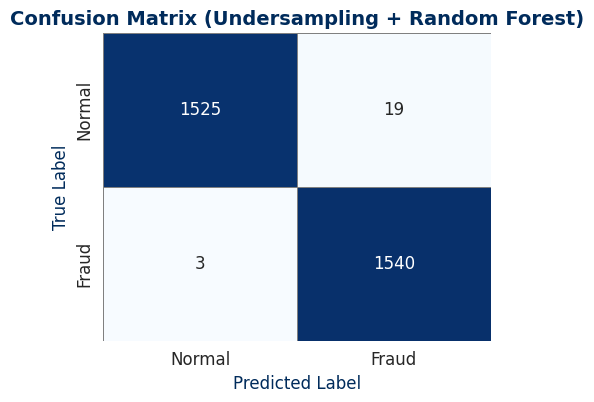

In [ ]:
cm = confusion_matrix(y_test, y_pred)
labels = ["Normal", "Fraud"]

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels,
            linewidths=0.5, linecolor="gray", cbar=False)
plt.title("Confusion Matrix (Undersampling + Random Forest)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

## Comparison 1 & 2
1. Pyspark + Ransom Forest + Class weight
2. Scikit-learn + Random Forest + Undersampling

In [ ]:
🎯 Model Performance:
   AUC-ROC:   0.9938
   AUC-PR:    0.6336
   Precision: 0.0284
   Recall:    0.9579
   F1-Score:  0.9782

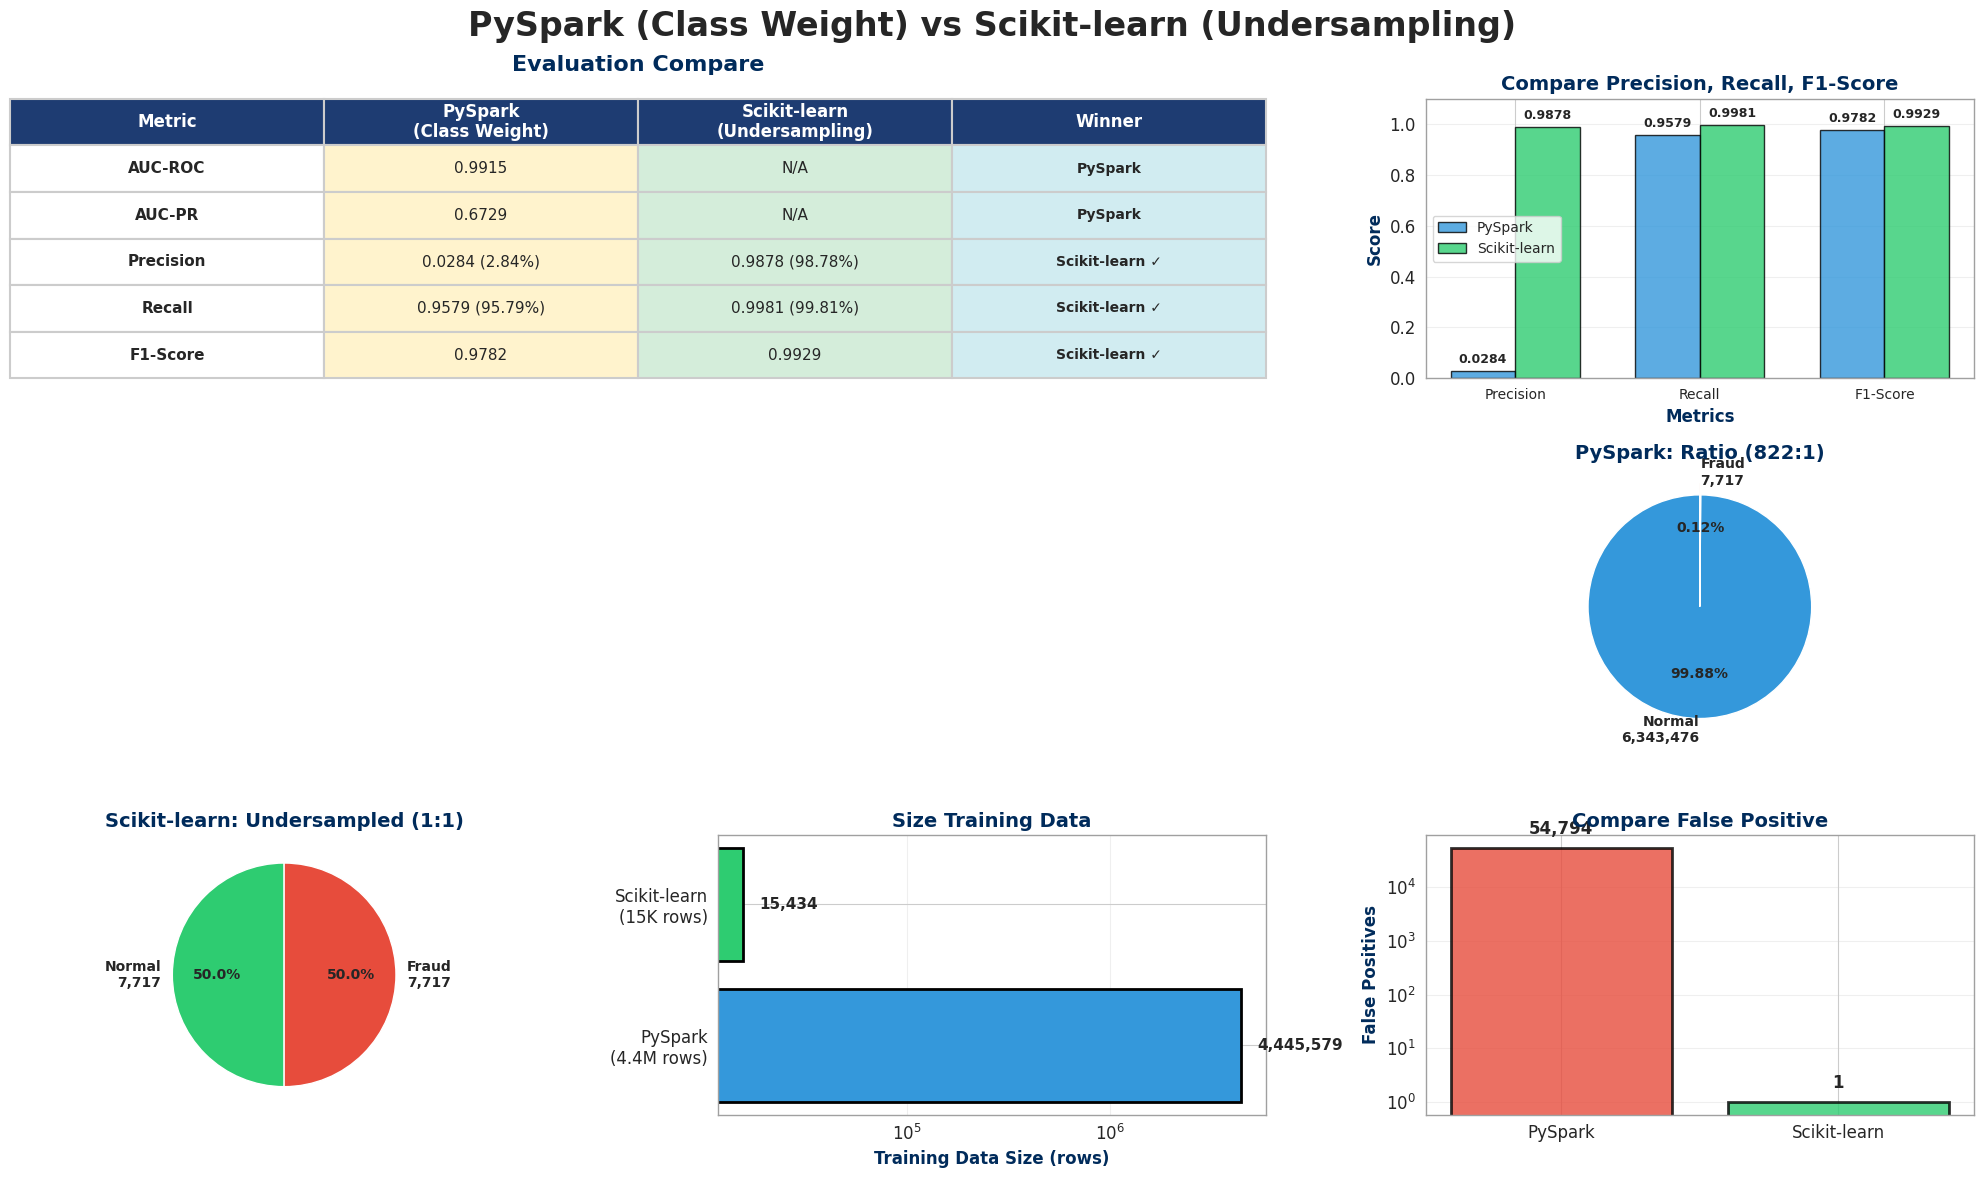

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle

methods = ['PySpark\n(Class Weight)', 'Scikit-learn\n(Undersampling)']


metrics_data = {
    'Metric': ['AUC-ROC', 'AUC-PR', 'Precision', 'Recall', 'F1-Score'],
    'PySpark': [0.9938, 0.6336, 0.0284, 0.9579, 0.9782],
    'Scikit-learn': [None, None, 0.9878, 0.9981,  0.9929]
}

fig = plt.figure(figsize=(20, 12))
fig.suptitle('PySpark (Class Weight) vs Scikit-learn (Undersampling)',
             fontsize=24, fontweight='bold', y=0.98)


ax1 = plt.subplot(3, 3, (1, 2))
ax1.axis('tight')
ax1.axis('off')

table_data = [
    ['Metric', 'PySpark\n(Class Weight)', 'Scikit-learn\n(Undersampling)', 'Winner'],
    ['AUC-ROC', '0.9915', 'N/A', 'PySpark'],
    ['AUC-PR', '0.6729', 'N/A', 'PySpark'],
    ['Precision', '0.0284 (2.84%)', '0.9878 (98.78%)', 'Scikit-learn ✓'],
    ['Recall', '0.9579 (95.79%)', '0.9981 (99.81%)', 'Scikit-learn ✓'],
    ['F1-Score', '0.9782', '0.9929', 'Scikit-learn ✓']
]

colors = [['#1e3c72']*4]  # Header
colors += [['white', '#fff3cd', '#d4edda', '#d1ecf1']] * 5  # Data rows

table = ax1.table(cellText=table_data, cellLoc='center', loc='center',
                  cellColours=colors, bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 3)

# Color & style
for i in range(len(table_data)):
    for j in range(len(table_data[0])):
        cell = table[(i, j)]
        if i == 0:  # Header
            cell.set_text_props(weight='bold', color='white', size=12)
            cell.set_facecolor('#1e3c72')
        else:
            if j == 0:  # Metric names
                cell.set_text_props(weight='bold', size=11)
            elif j == 3:  # Winner column
                cell.set_text_props(weight='bold', size=10)
        cell.set_edgecolor('#cccccc')
        cell.set_linewidth(1.5)

ax1.set_title('Evaluation Compare', fontsize=16, fontweight='bold', pad=20)

# Precision, Recall
ax2 = plt.subplot(3, 3, 3)
metrics_compare = ['Precision', 'Recall', 'F1-Score']
pyspark_values = [0.0284, 0.9579, 0.9782]
sklearn_values = [0.9878, 0.9981, 0.9929]

x = np.arange(len(metrics_compare))
width = 0.35

bars1 = ax2.bar(x - width/2, pyspark_values, width, label='PySpark',
                color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax2.bar(x + width/2, sklearn_values, width, label='Scikit-learn',
                color='#2ecc71', alpha=0.8, edgecolor='black')

ax2.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax2.set_ylabel('Score', fontsize=12, fontweight='bold')
ax2.set_title('Compare Precision, Recall, F1-Score', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics_compare, fontsize=10)
ax2.set_ylim(0, 1.1)
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)


for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')



# Data Distribution - PySpark
ax5 = plt.subplot(3, 3, 6)
data_pyspark = [6343476, 7717]
labels_data = ['Normal\n6,343,476', 'Fraud\n7,717']
colors_pie = ['#3498db', '#e74c3c']
explode = (0, 0.1)

wedges, texts, autotexts = ax5.pie(data_pyspark, labels=labels_data, autopct='%1.2f%%',
                                     startangle=90, colors=colors_pie, explode=explode,
                                     textprops={'fontsize': 10, 'weight': 'bold'})
ax5.set_title('PySpark: Ratio (822:1)', fontsize=14, fontweight='bold')

# Data Distribution - Scikit-learn
ax6 = plt.subplot(3, 3, 7)
data_sklearn = [7717, 7717]  # After undersampling
labels_sklearn = ['Normal\n7,717', 'Fraud\n7,717']
colors_pie2 = ['#2ecc71', '#e74c3c']

wedges2, texts2, autotexts2 = ax6.pie(data_sklearn, labels=labels_sklearn, autopct='%1.1f%%',
                                        startangle=90, colors=colors_pie2,
                                        textprops={'fontsize': 10, 'weight': 'bold'})
ax6.set_title('Scikit-learn: Undersampled (1:1)', fontsize=14, fontweight='bold')

# Training Data Size
ax7 = plt.subplot(3, 3, 8)
train_sizes = [4445579, 15434]  # PySpark full vs Sklearn after undersampling
method_names = ['PySpark\n(4.4M rows)', 'Scikit-learn\n(15K rows)']
bars = ax7.barh(method_names, train_sizes, color=['#3498db', '#2ecc71'],
                edgecolor='black', linewidth=2)
ax7.set_xlabel('Training Data Size (rows)', fontsize=12, fontweight='bold')
ax7.set_title('Size Training Data', fontsize=14, fontweight='bold')
ax7.set_xscale('log')
ax7.grid(axis='x', alpha=0.3)

for i, (bar, size) in enumerate(zip(bars, train_sizes)):
    ax7.text(size * 1.2, i, f'{size:,}', va='center', fontsize=11, fontweight='bold')

#  False Positive Comparison
ax8 = plt.subplot(3, 3, 9)
fp_data = [54794, 1]  # False Positives
method_names_fp = ['PySpark', 'Scikit-learn']
bars_fp = ax8.bar(method_names_fp, fp_data, color=['#e74c3c', '#2ecc71'],
                  edgecolor='black', linewidth=2, alpha=0.8)
ax8.set_ylabel('False Positives', fontsize=12, fontweight='bold')
ax8.set_title('Compare False Positive', fontsize=14, fontweight='bold')
ax8.set_yscale('log')
ax8.grid(axis='y', alpha=0.3)

for bar, fp in zip(bars_fp, fp_data):
    height = bar.get_height()
    ax8.text(bar.get_x() + bar.get_width()/2., height * 1.5,
            f'{fp:,}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('fraud_detection_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Another Plots

In [ ]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['axes.labelcolor'] = "#002B5B"
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = "bold"
plt.rcParams['axes.titlecolor'] = "#002B5B"
plt.rcParams['axes.edgecolor'] = "#A0A0A0"
plt.rcParams['axes.linewidth'] = 1.0

# Dummy data for visualization
train_size = 0.7
test_size = 0.3
normal_count = 6_343_476
fraud_count = 7_717
metrics = {
    'AUC-ROC': 0.9915,
    'AUC-PR': 0.6729,
    'Precision': 0.0379,
    'Recall': 0.9200,
    'F1-Score': 0.9842
}
conf_matrix = np.array([[1848471, 54794],
                        [188, 2161]])
feature_importance = {
    'PCA_Component_1': 0.05,
    'PCA_Component_2': 0.10,
    'PCA_Component_3': 0.08,
    'PCA_Component_4': 0.13,
    'PCA_Component_5': 0.64
}

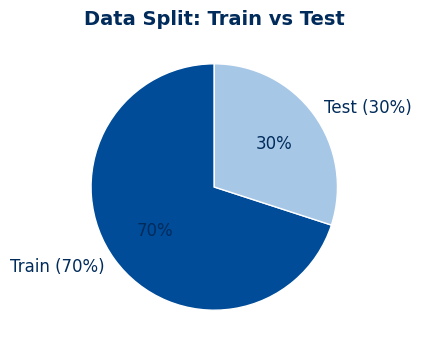

In [ ]:
labels = ['Train (70%)', 'Test (30%)']
sizes = [train_size, test_size]
colors = ['#004C99', '#A7C7E7']

plt.figure()
plt.pie(sizes, labels=labels, autopct='%1.0f%%', startangle=90, colors=colors, textprops={'color':'#002B5B'})
plt.title("Data Split: Train vs Test")
plt.show()

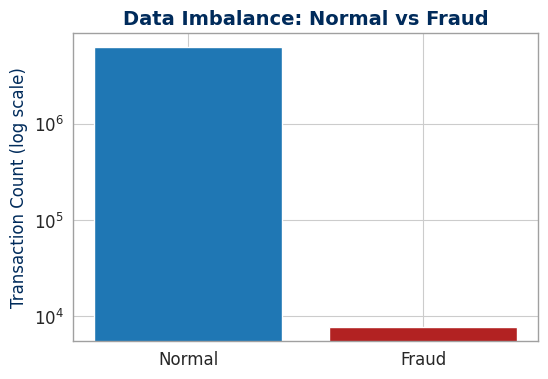

In [ ]:
plt.figure()
plt.bar(['Normal', 'Fraud'], [normal_count, fraud_count], color=['#1F77B4','#B22222'])
plt.yscale('log')
plt.ylabel('Transaction Count (log scale)')
plt.title("Data Imbalance: Normal vs Fraud")
plt.show()

/tmp/ipython-input-4193505044.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(names), y=list(values), palette="Blues_d")


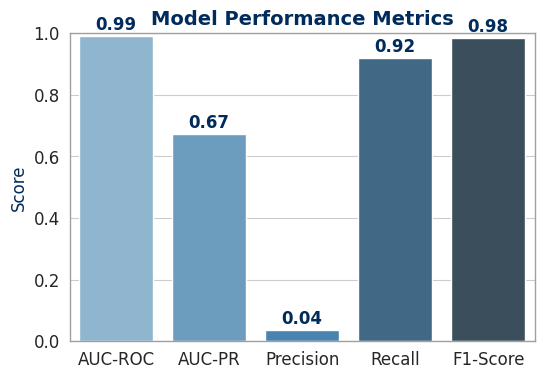

In [ ]:
plt.figure()
names, values = zip(*metrics.items())
sns.barplot(x=list(names), y=list(values), palette="Blues_d")
plt.title("Model Performance Metrics")
plt.ylim(0,1)
plt.ylabel("Score")
for i,v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', color='#002B5B', fontweight='bold')
plt.show()